# Implement Global LGBM Forecasting Model

***

`sktime` is dedicated to local forecasting reduction techniques, i.e., applied to one series at a time. So, we will not be able to use the full `sktime` pipeline when forecasting with a global model.

We borrow code from the `sktime` documentation [here](https://www.sktime.org/en/v0.6.1/examples/01_forecasting.html) that implements a recursive reduction forecasting strategy and apply it to all of the series in the data.

***

In [1]:
# general modules
import numpy as np
import pandas as pd

# light gradient boosting model package
import lightgbm as lgb

#### sktime functions ####

# import trend forecaster to detrend data
from sktime.forecasting.trend import PolynomialTrendForecaster

# import detrender and deseasonalizer
from sktime.transformations.series.detrend import Detrender, Deseasonalizer

# import mean absolute error and mean squared error metrics (specify square root in function)
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error

# nice time series plots
from sktime.utils.plotting import plot_series

In [2]:
# import weekly finance time series
Y = np.genfromtxt("../../../Data/Train/Clean/weekly_finance_clean.csv", delimiter = ',', skip_header = 1)

In [3]:
# store the number of series and number of time periods
num_series, num_periods = Y.shape

In [4]:
series_means = np.mean(Y, axis=1).reshape(num_series, 1)

In [5]:
# time series normalization and log transform
Y_t = np.log(Y/series_means)

In [6]:
# convert to series to use with SOME sktime functions
Y_t = pd.DataFrame(Y_t)

In [7]:
# forecast 20 periods out
fh = np.arange(1, 21)

In [8]:
# this function has tons of options to mess with, we use defaults here
regressor = lgb.LGBMRegressor()

In [9]:
y = Y_t.iloc[0,:]
window_length = 15

In [10]:
# slightly modified code from the M4 competition
def reduce_train_test(data, window_length, h):
    """
    Splits the series into train and test sets.

    Each step takes multiple points as inputs
    :param data: an individual series as an array
    :param h: number of out of sample points (forecast horizon length)
    :param window_length: window_length
    :return: reduced train and test datasets
    """

    train, test = data[:-h], data[-(h + window_length):]
    x_train, y_train = train[:-1], np.roll(train, -window_length)[:-window_length]
    x_test, y_test = test[:-1], np.roll(test, -window_length)[:-window_length]

    x_train = np.reshape(x_train, (-1, 1))
    x_test = np.reshape(x_test, (-1, 1))
    temp_test = np.roll(x_test, -1)
    temp_train = np.roll(x_train, -1)
    for x in range(1, window_length):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return x_train, y_train, x_test, y_test

In [11]:
#deseasonalizer = Deseasonalizer(sp=52, model="additive")
#y_ds = deseasonalizer.fit_transform(y)

In [12]:
#detrender = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
#y_ds_dt = detrender.fit_transform(y_ds)

In [13]:
#plot_series(y_ds_dt)

In [14]:
x_train, y_train, x_test, y_test = reduce_train_test(data=y.values,
                                                     window_length=window_length,
                                                     h = len(fh))

In [15]:
regressor.fit(x_train, y_train)

LGBMRegressor()

In [16]:
# slightly modified code from the M4 study
predictions = []
last_window = x_train[-1, :].reshape(1, -1)  # make it into 2d array

last_prediction = regressor.predict(last_window)[0]  # take value from array

for i in range(len(fh)):
    # append prediction
    predictions.append(last_prediction)

    # update last window using previously predicted value
    last_window[0] = np.roll(last_window[0], -1)
    last_window[0, (len(last_window[0]) - 1)] = last_prediction

    # predict next step ahead
    last_prediction = regressor.predict(last_window)[0]

# add back time index to y_test
y_train = pd.Series(np.concatenate([x_train[0,:], y_train]), index = y.index[:-len(fh)])
y_test = pd.Series(y_test, index=y.index[-len(fh) :])

y_pred_rec = pd.Series(predictions, index=y_test.index)
mean_absolute_error(y_pred_rec, y_test)

0.004031061974795988

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

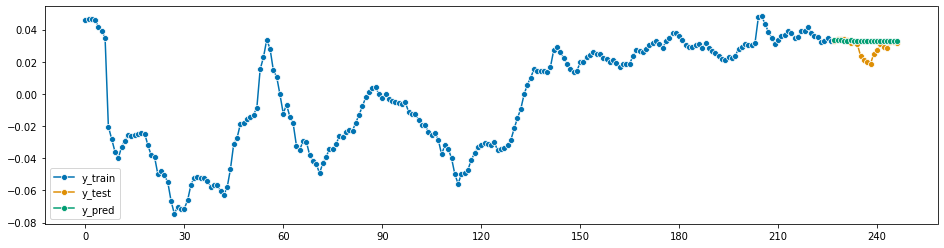

In [17]:
plot_series(y_train,
            y_test,
            y_pred_rec, 
            labels=["y_train", "y_test", "y_pred"])

Got the above working for one series, need to reduce all series, combine, fit a model, and use to generate forecasts for any series. Going to need to create a class?